# Rotterdam stylized case

In [1]:
from classes import *
import copy
from collections import OrderedDict
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
#import ipywidgets as widgets
import pickle

### Load the model with parameters

In [2]:
from models import Rotty
#global pars (for the development of Trust) Will be removed 
k = 0.2 
T_eq = 70
Rotty

Rotty 
-----------
allFloodProtection: 
No 3.5; Dike 4.5;  
-----------
allResidentialArea: 
Area_A Protected by:['No']
Area_B Protected by:['Dike']

Parameters : 
{'alarming_conditions': OrderedDict([(1, ['Major flood', 40]), (0, ['Small flood', 20]), (-0.2, ['Near miss', 10]), (-0.4, ['Major wake-up', 7]), (-1, ['Minor wake-up', 5]), (-10, ['Nothing happens', 0])]), 'Gumbel': OrderedDict([('mu', 2.33), ('beta', 0.234)]), 'Bayesian_weighing_constants': OrderedDict([('a_noflood', 1), ('a_flood', 0.1), ('b_noflood', 0.04), ('b_flood', 1), ('c', 0), ('d', 0.2)]), 'I_experience_interp': {'xp': [0, 0.5], 'fp': [0, 1]}}

### Load storm surge scenarios

In [3]:
# Load all SLR_Scenario
for filename in os.listdir("SLR_projections"):
    if filename.endswith(".csv"):
        obj = SLR_Scenario(filename.split('.')[0]) #Init object with name derived from filename
        obj.from_csv(os.path.join('SLR_projections',filename)) #Fill the object with data from the csv file

# Load all SurgeHeight (Realisations of extreme value distribution)
for filename in os.listdir("SurgeHeight"):
    if filename.endswith(".csv"):
        obj = SurgeHeight(filename.split('.')[0]) #Init object with name derived from filename
        obj.from_csv(os.path.join('SurgeHeight',filename)) #Fill the object with data from the csv file

# Create SurgeLevels by summing combinations of SLR_Scenario and SurgeHeights
for SLR_Scenario in allSLR_Scenario:
    for SurgeHeight in allSurgeHeight:
        combine_SurgeLevel(SLR_Scenario,SurgeHeight)
        
# Print all available SLR scenarios
for SLR_Scenario in allSLR_Scenario:
    print(SLR_Scenario.name,end=' ||| ')

Bamber_2019_high_17 ||| Bamber_2019_high_5 ||| Bamber_2019_high_50 ||| Bamber_2019_high_83 ||| Bamber_2019_high_95 ||| LeBars_2017_RCP45_05 ||| LeBars_2017_RCP45_95 ||| LeBars_2017_RCP45_med ||| LeBars_2017_RCP85_05 ||| LeBars_2017_RCP85_95 ||| LeBars_2017_RCP85_med ||| SROCC_2019_RCP26_17 ||| SROCC_2019_RCP26_50 ||| SROCC_2019_RCP26_83 ||| SROCC_2019_RCP45_17 ||| SROCC_2019_RCP45_50 ||| SROCC_2019_RCP45_83 ||| SROCC_2019_RCP85_17 ||| SROCC_2019_RCP85_50 ||| SROCC_2019_RCP85_83 ||| 

### Run this block if you want to focus on a subset of the scenarios

In [4]:
# Make a manual preselection of scenarios to simplify plots
transient = "2"
selection = [x for x in allSurgeLevel if x.name.split("__")[1] == transient] #only run experiments for one of the transients
selection = [x for x in selection if x.name.split('__')[0] in ['SROCC_2019_RCP26_17','SROCC_2019_RCP85_50','SROCC_2019_RCP85_83','Bamber_2019_high_95']]
selection

[Bamber_2019_high_95__2,
 SROCC_2019_RCP26_17__2,
 SROCC_2019_RCP85_50__2,
 SROCC_2019_RCP85_83__2]

### Load adaptation strategies (Mayors)

In [5]:
from mayors import *
allMayors = [Kroket(),Economicus(),Sentiment(),Lawkeeper()]

### Model run algorithm

In [6]:
def run_model(Model,SurgeLevel,Mayor,do_print=False):  
    #REMOVE ALL ACTIVE MEASURES FROM PREVIOUS RUNS
    allactiveMeasure.clear()
    
    time = SurgeLevel.years
    init_time(Model,time) #Initiate time for objects that have changing variables over time

    # THE MODEL RUNS OVER A YEARLY TIMESTEP
    for i,t in enumerate(time): #Iterate over the years t, with index i
        #print(i,t, end=" |")
        
        for Area in Model.allResidentialArea:
            
            #FIRST EVALUATE IF THE FLOOD PROTECTION LEVEL IS EXCEEDED 
            if Area.protection_level[i] < SurgeLevel.surgelevel[i]: #if a flood occurs; TODO EVALUATE FROM FLOOD_HISTORY
                Area.flood_history[i] = SurgeLevel.surgelevel[i] - Area.elevation #Can also be negative (no flood!)
                
                Area.flood_damage[i] = Area.calculate_damage(Area.flood_history[i],i)
                #print("Damage is calculated at: {} euro".format(dam))
            
            #AND EVALUATE IF ANY NEAR MISS MIGHT HAVE OCCURED
            if 0 < Area.protection_level[i] - SurgeLevel.surgelevel[i] <= 0.5: #Near miss
                Area.nearmiss_history[i] = Area.protection_level[i] - SurgeLevel.surgelevel[i]
            
            
            #THEN EVALUATE THE IMPACT ON TRUST #DEPRECIATED, TO BE REPLACE WITH BAYESIAN STUFF
            if i != 0: #don't evaluate trust in the first timestep!
                #print(Area.protection_level-levels_t[i])
                Area.event_impact_history[i] = evaluate_event(SurgeLevel.surgelevel[i]-Area.protection_level[i],
                                                              Model.Parameters['alarming_conditions'],False)
                #First evaluate the impact of this year's event (if any)
                Area.trust_t[i] = Area.trust_t[i-1] - Area.event_impact_history[i]

                #ALWAYS MODEL RECOVERY OF TRUST
                dTdt = (Area.trust_t[i]-T_eq)*-k
                Area.trust_t[i] = Area.trust_t[i] + dTdt

        
        for RA in Model.allResidentialArea:
            
            #CALCULATE THE OBJECTIVE RISK IN THIS TIMESTEP
            mu = Model.Parameters["Gumbel"]["mu"]
            beta = Model.Parameters["Gumbel"]["beta"]
            SLR = SurgeLevel.corresponding_SLR_Scenario.sealevel[i] #the degree of SLR in this timestep
            #SLR = relevant_TS.surgelevel[i] #todo change name to SLR to avoid confusion!!
            max_surge = RA.protection_level[i]-SLR #the maximum storm surge level this dike can cope with
            RA.protection_level_rp[i] = Gumbel_RP(max_surge,mu,beta) #Return period of the flood protection level
            RPs = [10000,5000,2000,1000,500,200,100,50,20,10,5,2]
            damages = []
            for RP in RPs:
                #Expected water levels are the sum of the Gumbel distributed WLs 
                waterlevel = Gumbel_inverse(RP,mu,beta) + SLR
                inundation = waterlevel - RA.elevation
                damages.append(RA.calculate_damage(inundation,i)) #damage assuming no FPL
            RA.risk[i] = risk_FP(damages.copy(),RPs.copy(),RA.protection_level_rp[i])*10**(-6) #EAD in million 2010-euro's 
            
            #CALCULATE THE RISK PERCEPTION
            if i != 0: #skip in the first timestep (here the initial condition is used)
                I_exp = 0; #the flood experience in the current timestep
                #RA.weigh_RP_Bayesian(i,Model.Parameters["Bayesian_weighing_constants"],Model.Parameters["I_experience_interp"])
                RA.weigh_RP_Bayesian(i,Model.Parameters["I_experience_interp"])
            
            RA.risk_perceived[i] = risk_FP(damages.copy(), #Copy of the damages
                                           shift_subjective_floods(RPs.copy(),RA.risk_perception[i]), #perceived return periods
                                           shift_subjective_floods(RA.protection_level_rp[i],RA.risk_perception[i]))*10**(-6) #return period of flood protection
                
        #IMPLEMENT FLOOD PROTECTION MEASURES
        Mayor.apply_strategy(Model,SurgeLevel,i,time)
        for measure in allactiveMeasure: #tell all measures that are currently planned that a timestep has passed and that their implementation is coming near 
            measure.countdown(i,len(time)) #we need to tell the measure instances which timestep it is
        
        for Area in Model.allResidentialArea: #kan naar hierboven! als method van measure
               Area.match_with_FloodProtection(Model.allFloodProtection)
    
    experiment = Experiment(Model,SurgeLevel,Mayor)
    
    if do_print:
        print("Finished experiment {}".format(experiment))
    
    return experiment

def init_time(Model,time,do_print=False):
    """
    Initiate all variables that change over time for all relevant objects
    And matches all areas with flood protection objects
    
    Arguments:
        *Model* (Urban-SETP model object) : The model of the city
        *time* (list) : Timeseries of all years for which the model is to run
        
    Return:
        *Model* (Urban-SETP model object) : The model of the city with time initiated
    
    """
    for FloodProtection in Model.allFloodProtection:
        FloodProtection.init_time(time)             

    for Area in Model.allResidentialArea:
        Area.match_with_FloodProtection(Model.allFloodProtection) #ADD THE INFORMATION OF THE FLOOD PROTECTION STRUCTURES TO THE AREAS IT PROTECTS
        Area.init_time(time) #create all the variables that are manipulated over time
    
    if do_print:
        print('Time is initiated for all Flood protection and Residential Area objects')
    return Model


# Run the behaviour of one Mayor

In [11]:
#run one mayor:
mayor_experiments = []
for SurgeLevel in selection:
    experiment = run_model(Rotty,SurgeLevel,Economicus(),do_print=True)
    mayor_experiments.append(experiment)
print('experiments finished')

Finished experiment Rotty_Bamber_2019_high_95__2_H. Economicus 2020/08/21, 16:29:15
Finished experiment Rotty_SROCC_2019_RCP26_17__2_H. Economicus 2020/08/21, 16:29:15
Finished experiment Rotty_SROCC_2019_RCP85_50__2_H. Economicus 2020/08/21, 16:29:15
Finished experiment Rotty_SROCC_2019_RCP85_83__2_H. Economicus 2020/08/21, 16:29:15
experiments finished


Target folder Visualisations\2020_8_21 already exists


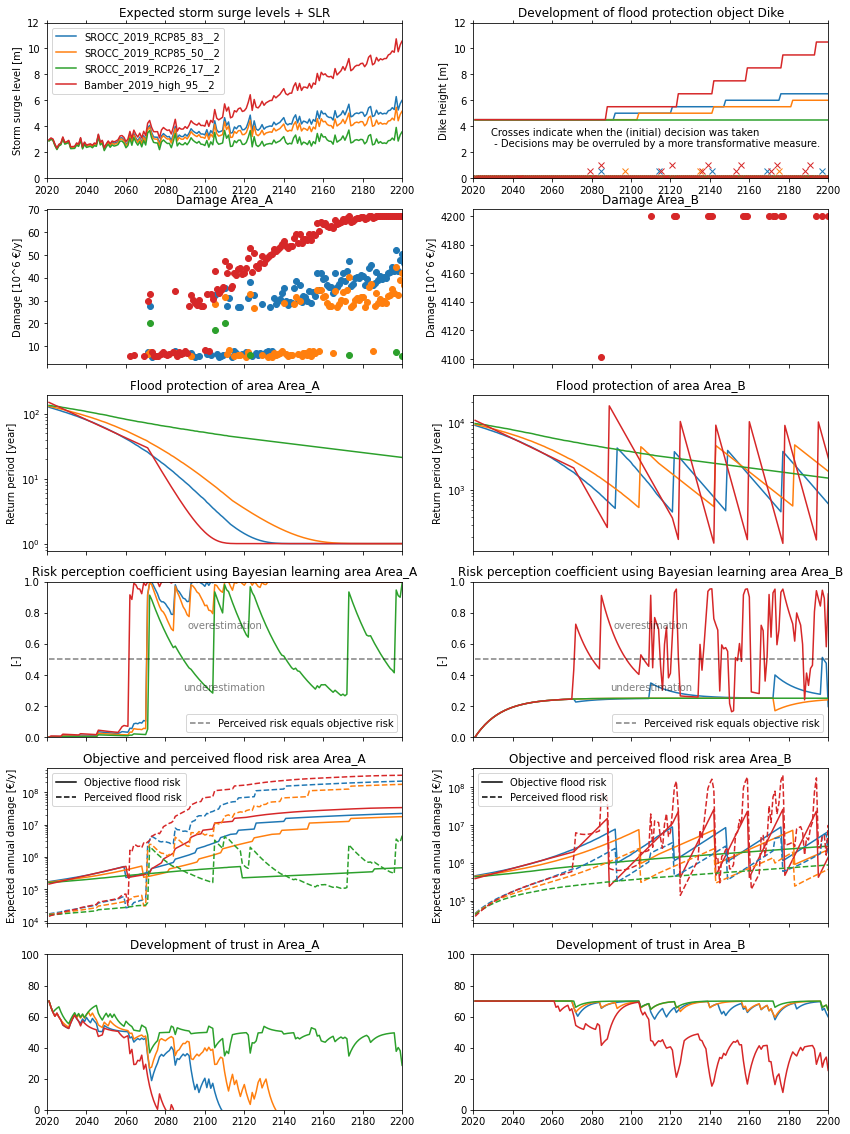

In [28]:
fig, axes = plt.subplots(nrows=6,ncols=2,sharey=False,sharex=True,figsize=(14,20))

labels = []

for experiment in reversed(mayor_experiments):
    
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    Mayor = experiment.Mayor
    
    #print(SurgeLevel.name
    
    axes[0,0].plot(SurgeLevel.years,SurgeLevel.surgelevel)

    labels.append(SurgeLevel.name)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    #axes[0,0].set_xlabel('Time [year]')
    axes[0,0].set_ylabel('Storm surge level [m]')
    axes[0,0].set_ylim(0,12)
    axes[0,1].set_ylim(0,12)
    axes[0,1].set_ylabel('Dike height [m]')
    
    axes[0,0].set_xlim(2020,2200)

    for i, Area in enumerate(Model.allResidentialArea):
        axes[0,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
       
           
        #plot damage
        axes[1,i].set_title('Damage {}'.format(Area.name))
        axes[1,i].plot(SurgeLevel.years,[x*10**(-6) for x in Model.allResidentialArea[i].flood_damage],'o')
        axes[1,i].set_ylabel('Damage [10^6 \u20ac/y]')
        #axes[1,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[2,i].set_title('Flood protection of area {}'.format(Model.allResidentialArea[i].name))
        axes[2,i].plot(SurgeLevel.years,Model.allResidentialArea[i].protection_level_rp,'-')
        axes[2,i].set_yscale("log")
        axes[2,i].set_ylabel('Return period [year]')
        #axes[2,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
    
        axes[3,i].set_title('Risk perception coefficient using Bayesian learning area {}'.format(Model.allResidentialArea[i].name))
        axes[3,i].plot(SurgeLevel.years,Model.allResidentialArea[i].risk_perception,'-')
        axes[3,i].set_ylabel('[-]')
        axes[3,i].set_ylim(0,1)
        

        
        
        #axes[3,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        
        axes[4,i].set_title('Objective and perceived flood risk area {}'.format(Model.allResidentialArea[i].name))
        unit_corr = [x * 10**6 for x in Model.allResidentialArea[i].risk]
        axes[4,i].plot(SurgeLevel.years,unit_corr,'-')
        axes[4,i].set_yscale("log")
        axes[4,i].set_ylabel('Expected annual damage [\u20ac/y]')
        #axes[4,i].tick_params(axis='x',reset=True) # to repeat the x-labels along the axes
        #Manually add legend patches
        custom_lines = [Line2D([0], [0], color='black',label='Objective flood risk',linestyle='-'),
                        Line2D([0], [0], color='black',label='Perceived flood risk',linestyle='--')]
        axes[4,i].legend(handles=custom_lines)
                            
        axes[5,i].set_title('Development of trust in {}'.format(Area.name))
        axes[5,i].plot(SurgeLevel.years,Model.allResidentialArea[i].trust_t)
        axes[5,i].set_ylim(0,100)
    
    axes[0,1].plot(SurgeLevel.years,Model.allFloodProtection[1].protection_level)
    axes[0,1].set_title('Development of flood protection object Dike')
    
axes[0,0].legend(labels)



#Add some additional text to some axes
#alarming_conditions = Model.Parameters['alarming_conditions']
#textbox = ""
#for key in alarming_conditions:
#    textbox = textbox + str(alarming_conditions[key]) + '\n'
#axes[1,1].text(0.05,0.5,textbox,transform=axes[1,1].transAxes)

axes[0,1].text(0.05,0.2,"Crosses indicate when the (initial) decision was taken \n - Decisions may be overruled by a more transformative measure.",transform=axes[0,1].transAxes)



axes[0,1].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
axes[4,0].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
axes[4,1].set_prop_cycle(None) #reset the cycler to plot again in the same axes with similar colors
for experiment in reversed(experiments):
    Model = experiment.Model
    SurgeLevel = experiment.SurgeLevel
    Mayor = experiment.Mayor    
    
    axes[0,1].plot(SurgeLevel.years,Model.allFloodProtection[1].measure_history,'x') #PLOT THE HISTORY OF THE MEASURES
    


    #axes[5,i].set_title('Subjective/perceived flood risk (EAD) in million euro per year {}'.format(Model.allResidentialArea[i].name))
    for i, Area in enumerate(Model.allResidentialArea):
        unit_corr = [x * 10**6 for x in Model.allResidentialArea[i].risk_perceived]
        axes[4,i].plot(SurgeLevel.years,unit_corr,'--')
        

#PRINT THE THRESHOLD PROTECTION LEVELS FOR THE LAWKEEPER MAYOR
if Mayor.get_name() == 'Lawkeeper':
    axes[2,1].plot(SurgeLevel.years,[Mayor.threshold_small]*len(SurgeLevel.years),color='black',linestyle='--',alpha=0.5)
    axes[2,1].plot(SurgeLevel.years,[Mayor.threshold_large]*len(SurgeLevel.years),color='black',linestyle='--',alpha=0.5)
    axes[2,1].text(2030,Mayor.threshold_small - 4000,'Threshold small measure',color='black',alpha=1)
    axes[2,1].text(2030,Mayor.threshold_large - 800,'Threshold large measure',color='black',alpha=1)
    
for j in [0,1]:
    alpha = 0.5
    color = 'black'
    axes[3,j].plot(SurgeLevel.years,[0.5]*len(SurgeLevel.years),color=color,linestyle='--',alpha = alpha)    
    #Manually add legend patches
    custom_line = [Line2D([0], [0], color=color, alpha=alpha,label='Perceived risk equals objective risk',linestyle='--')]
    axes[3,j].legend(handles=custom_line)
    axes[3,j].text(0.5,0.3,'underestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')
    axes[3,j].text(0.5,0.7,'overestimation',color=color,alpha=alpha,transform=axes[3,j].transAxes,ha='center')

    
#################################################################    
#################### SAVE THE EXPERIMENT ########################
#################################################################


filename = experiment.Mayor.get_name() + "_trans_" + experiment.SurgeLevel.name.split("__")[1]

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
foldername = date
target = os.path.join('Visualisations',foldername)
if not os.path.exists(target):
    os.mkdir(target)
else:
    print("Target folder {} already exists".format(target))
    

#fig.savefig(os.path.join(target,filename + ".png"),bbox_inches='tight',dpi=150)

In [21]:
experiment.Model.allResidentialArea[0].__dict__.keys()

dict_keys(['name', 'elevation', 'surface_area', 'inhabitants', 'nr_houses', 'house_price_0', 'dam_pars', 'protected_by', 'description', 'Bayesian_pars', 'protection_level', 'trust_t', 'event_impact_history', 'flood_history', 'nearmiss_history', 'flood_damage', 'risk', 'protection_level_rp', 'risk_perception', 'risk_perceived', 'flood_proofing'])

In [33]:

def Average(lst): 
    return sum(lst) / len(lst) 

Average(experiment.Model.allResidentialArea[0].protection_level_rp[0:10])

114.20521947033396

# Run all Mayors

In [12]:
#run all Majors
allExperiments = []
for SurgeLevel in selection:
    #print("\n \n {} \n\n------------- \n\n".format(SurgeLevel.name))
    for Mayor in allMayors:
        experiment = run_model(Rotty,SurgeLevel,Mayor,do_print=True)
        allExperiments.append(experiment)
print('experiments finished')

Finished experiment Rotty_Bamber_2019_high_95__2_R. Active 2020/08/21, 16:29:58
Finished experiment Rotty_Bamber_2019_high_95__2_H. Economicus 2020/08/21, 16:29:58
Finished experiment Rotty_Bamber_2019_high_95__2_Sentiment 2020/08/21, 16:29:58
Finished experiment Rotty_Bamber_2019_high_95__2_Lawkeeper 2020/08/21, 16:29:58
Finished experiment Rotty_SROCC_2019_RCP26_17__2_R. Active 2020/08/21, 16:29:58
Finished experiment Rotty_SROCC_2019_RCP26_17__2_H. Economicus 2020/08/21, 16:29:59
Finished experiment Rotty_SROCC_2019_RCP26_17__2_Sentiment 2020/08/21, 16:29:59
Finished experiment Rotty_SROCC_2019_RCP26_17__2_Lawkeeper 2020/08/21, 16:29:59
Finished experiment Rotty_SROCC_2019_RCP85_50__2_R. Active 2020/08/21, 16:29:59
Finished experiment Rotty_SROCC_2019_RCP85_50__2_H. Economicus 2020/08/21, 16:29:59
Finished experiment Rotty_SROCC_2019_RCP85_50__2_Sentiment 2020/08/21, 16:29:59
Finished experiment Rotty_SROCC_2019_RCP85_50__2_Lawkeeper 2020/08/21, 16:29:59
Finished experiment Rotty_SR

### Save EXPERIMENTS as pickle

In [9]:
foldername = "temp"
subfolder = "experiments"
target = os.path.join(foldername,subfolder)

today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)

if not os.path.exists(foldername):
    os.mkdir(foldername)
    if not os.path.exists(target):
        os.mkdir(target)

pickle.dump(experiments, open( os.path.join(target,"experiment_" + date +  ".p"), "wb") ) 

In [ ]:
experiments

### Save as image

In [ ]:
filename = experiment['Mayor'].get_name() + "_trans_" + experiment['SurgeLevel'].name.split("__")[1]

#CREATE SUBFOLDER IN VISUALISATION WITH CURRENT DATE
today = datetime.date(datetime.now())
date = "{}_{}_{}".format(today.year,today.month,today.day)
foldername = date
target = os.path.join('Visualisations',foldername)
if not os.path.exists(target):
    os.mkdir(target)
else:
    print("Target folder {} already exists".format(target))
    

#fig.savefig(os.path.join(target,filename + ".png"),bbox_inches='tight',dpi=150)

### Plot one experiment in which you are interested

In [ ]:
# select the model in the experiment
#experiment = experiments[-1] #the last experiment
#experiment['Model']

experiment = run_model(Rotty,selection[3],Economicus())
experiment

In [19]:
if hasattr(Rotty.allResidentialArea[0], 'name'):
    print('Attribuut bestaat')
else:
    print('bestaat niet')

Attribuut bestaat


In [18]:
Rotty.allResidentialArea[0].__dict__

{'name': 'Area_A',
 'elevation': 3,
 'surface_area': 0.4,
 'inhabitants': 1500,
 'nr_houses': 750,
 'house_price_0': 300000,
 'dam_pars': (168,
  [0, 0.5, 1, 1.5, 2, 3, 4, 5, 6],
  [0, 0.25, 0.4, 0.5, 0.6, 0.75, 0.85, 0.95, 1.0]),
 'protected_by': ['No'],
 'description': 'Residential area A: the Heijplaat',
 'Bayesian_pars': <classes.Bayesian_pars at 0x256a0823e80>}

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=2,sharey=False,sharex=True,figsize=(14,14))

labels = []

    
Model = experiment['Model']
SurgeLevel = experiment['SurgeLevel']
Mayor = experiment['Mayor']



for i, Area in enumerate(Model.allResidentialArea):
    #plot the water depths and the protection level
    axes[0,i].plot(SurgeLevel.years,SurgeLevel.surgelevel)

    labels.append(SurgeLevel.name)
    axes[0,0].set_title('Expected storm surge levels + SLR')
    axes[0,0].set_xlabel('Time (years)')
    axes[0,0].set_ylabel('Storm surge level (m)')
    axes[0,0].set_ylim(0,8)
    axes[0,1].set_ylim(0,8)
    
    axes[0,i].plot(SurgeLevel.years,Model.allResidentialArea[i].protection_level)

    #plot the flood history (inundation depth) per residential Area.
    axes[1,i].set_title('Inundation depth [m] {}'.format(Area.name))
    axes[1,i].plot(SurgeLevel.years,Model.allResidentialArea[i].flood_history,'o',SurgeLevel.years,[0]*len(SurgeLevel.years))
    axes[1,i].plot(SurgeLevel.years, Model.allResidentialArea[i].nearmiss_history,'o')


    axes[2,i].set_title('Risk perception according to Bayesian learning')
    axes[2,i].plot(SurgeLevel.years,Model.allResidentialArea[i].risk_perception,'-')




axes[0,1].set_title('Development of flood protection object Dike')
    

    